
<a href="https://githubtocolab.com/Astolfo2332/space_inv_agent/blob/main/proyecto_practico.ipynb" target="_parent\">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" > </a>


# Proyecto práctico: Agents en Space Invaders

repositorio: [Astolfo2332/space_inv_agent](https://github.com/Astolfo2332/space_inv_agent)

Por:
- [Miguel López Vélez](https://github.com/Astolfo2332) id 1001014378
- [Azahara Cortés Mañanes](https://github.com/nirett)


---
## **PARTE 1**. Enunciado

Consideraciones a tener en cuenta:

- El entorno sobre el que trabajaremos será _SpaceInvaders-v0_ y el algoritmo que usaremos será _DQN_.

- Para nuestro ejercicio, el requisito mínimo será alcanzado cuando el agente consiga una **media de recompensa por encima de 20 puntos en modo test**. Por ello, esta media de la recompensa se calculará a partir del código de test en la última celda del notebook.

Este proyecto práctico consta de tres partes:

1.   Implementar la red neuronal que se usará en la solución
2.   Implementar las distintas piezas de la solución DQN
3.   Justificar la respuesta en relación a los resultados obtenidos

**Rúbrica**: Se valorará la originalidad en la solución aportada, así como la capacidad de discutir los resultados de forma detallada. El requisito mínimo servirá para aprobar la actividad, bajo premisa de que la discusión del resultado sera apropiada.

IMPORTANTE:

* Si no se consigue una puntuación óptima, responder sobre la mejor puntuación obtenida.
* Para entrenamientos largos, recordad que podéis usar checkpoints de vuestros modelos para retomar los entrenamientos. En este caso, recordad cambiar los parámetros adecuadamente (sobre todo los relacionados con el proceso de exploración).
* Se deberá entregar unicamente el notebook y los pesos del mejor modelo en un fichero .zip, de forma organizada.
* Cada alumno deberá de subir la solución de forma individual.


## Importación de librerías

In [1]:
from IPython.display import display, Image
import plotly.io as pio
import numpy as np
import mlflow
from stable_baselines3 import DQN, A2C, PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch.nn as nn
import torch
import os
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, VecNormalize, VecEnvWrapper, SubprocVecEnv, VecVideoRecorder
from stable_baselines3.common.vec_env.vec_transpose import VecTransposeImage
from stable_baselines3.common.callbacks import ProgressBarCallback, BaseCallback
from stable_baselines3.common.monitor import Monitor

import gymnasium as gym
import ale_py

from tqdm.notebook import tqdm
import mlflow
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from stable_baselines3.common.atari_wrappers import AtariWrapper

from collections import Counter
from sb3_contrib import QRDQN

from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.sb2_compat.rmsprop_tf_like import RMSpropTFLike

from stable_baselines3.common.utils import get_linear_fn

import optuna
from optuna.visualization import plot_param_importances
from collections import defaultdict


### Configuración base

In [4]:
#Se usa la versión no framkeskip, ya que el AtariWrapper se encarga de ello
env_name = 'SpaceInvadersNoFrameskip-v4'
base_env = gym.make(env_name)
base_env.action_space.seed(23)

class NormalizeInput(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
    def observation(self, observation):
        return observation.astype(np.float32) / 255.0

def make_env_no_pen():
    def _init() -> gym.Env:
        normal_env = gym.make(env_name)
        normal_env.action_space.seed(23)
        # normal_env = NormalizeInput(normal_env)
        # AtariWrapper se encarga de reescalar la imagen, pasarla a gris, aplicar el frame skip y clipear las recompensas
        normal_env = AtariWrapper(normal_env, frame_skip=4)
        return normal_env
    return _init

dummy_env_pen = DummyVecEnv([make_env_no_pen()])
dummy_env_pen.seed(23)
dummy_env_pen = VecFrameStack(dummy_env_pen, n_stack=4)
dummy_env_pen = VecTransposeImage(dummy_env_pen)

np.random.seed(23)

# Estructura de salida sin los wrappers para sb3
obs, info = base_env.reset(seed=23)
print(obs.shape)

# Estructura de salida con los wrappers para sb3
obs = dummy_env_pen.reset()
print(obs.shape)


A.L.E: Arcade Learning Environment (version 0.11.1+2750686)
[Powered by Stella]


(210, 160, 3)
(1, 4, 84, 84)


**Aclaración importante**: No se estandariza la imagen entre 0 y 1 debido a que cuando este se realizan los entrenamientos pertinentes, esta no presenta signos de aprender, solo repite acciones de disparo (1) o movimiento y disparo (4, 5) en su totalidad, incluso con 10 millones de pasos y buscando hiperparámetros con optuna. Esto se especifica en el apartado de discusión y resultados.

### Penalizadores
Opcional, se prueba en algunas ocasiones con penalizadores para fomentar la búsqueda en etapas superiores de entrenamiento y evitar el "spam" de acciones.

In [ ]:
class CustomPenaltyWrapper(gym.Wrapper):
        def __init__(self, env):
            super().__init__(env)
            self.last_action = None
            self.same_action_count = 0
            self.last_lives = None
            self.no_shoot_count = 0
            self.no_score_count = 0
            self.killing_streak = 0
            self.tolerance_killing_streak = 5  # Tolerance for killing streak
            self.survival_reward = 0

            self.entropy_scale = 0.00001
            self.action_counts = defaultdict(int)
            self.total_actions = 0

        def reset(self, **kwargs):
            obs, info = self.env.reset(**kwargs)
            self.last_action = None
            self.same_action_count = 0
            self.no_shoot_count = 0
            self.no_score_count = 0
            self.killing_streak = 0
            self.tolerance_killing_streak = 5  # Reset tolerance
            self.survival_reward = 0

            return obs, info

        def step(self, action):
            obs, reward, terminated, truncated, info = self.env.step(action)
            # print("initial_reward:", reward)

            self.action_counts[action] += 1
            self.total_actions += 1

            p = self.action_counts[action] ** 2 / self.total_actions

            reward -= self.entropy_scale * p

            if reward == 0:
                self.no_score_count += 1
                self.tolerance_killing_streak -= 1
                if self.tolerance_killing_streak == 0:
                    self.killing_streak = 0
                    self.tolerance_killing_streak = 5  # Reset tolerance
            else:
                self.no_score_count = 0
                self.killing_streak += 1

            # reward = reward * self.killing_streak

            self.survival_reward += 1
            if self.survival_reward > 50:
                reward += 0.05
                self.survival_reward = 0

            if self.no_score_count >= 5:
                reward -= 0.00005

            # --- Penalty for repeated no-op
            if action == 0:
                if self.last_action == 0:
                    self.same_action_count += 1
                else:
                    self.same_action_count = 1
            else:
                self.same_action_count = 0
            self.last_action = action

            if self.same_action_count >= 3:
                reward -= 0.00005

            # --- Penalty for not shooting for too long
            if int(action) in [1, 4, 5]:  # shooting actions
                self.no_shoot_count = 0
            else:
                self.no_shoot_count += 1
                if self.no_shoot_count >= 10:
                    reward -= 0.00007

            reward = np.clip(reward, -1.0, 1.0)
            # reward = np.tanh(reward)

            return obs, reward, terminated, truncated, info

Basado en entropia para evitar el "spam" de acciones

In [ ]:
class CustomPenaltyWrapper(gym.Wrapper):
    def __init__(self, env, penalized_repeat=3e-7, entropy_coeff=1e-500):
        super().__init__(env)
        self.action_counter = defaultdict(int)
        self.penalized_repeat = penalized_repeat
        self.entropy_coeff = entropy_coeff

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.action_counter.clear()  # Reset action counter
        return obs, info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        # Update action counter
        self.action_counter[action] += 1
        total_actions = sum(self.action_counter.values())
        probs = np.array(
            [count / total_actions for count in self.action_counter.values()]
        )

        # Entropy: -∑p log p
        entropy = -np.sum(probs * np.log(probs + 1e-8))  # avoid log(0)
        entropy = entropy / 6

        # Reward shaping with entropy
        reward += self.entropy_coeff * entropy

        # Calculate entropy-based penalty
        total_actions = sum(self.action_counter.values())
        action_percentage = self.action_counter[action] / total_actions
        if action_percentage >= 0.5 and total_actions > 10:
            reward = 0

        return obs, reward, terminated, truncated, info


Más sin embargo, ninguno de los modelos finales usan los penalizadores, ya que no aportan mucho al rendimiento y en el peor de los casos los empeoran.

# 1. Implementación de la red neuronal

MobileNet

In [ ]:
class MobileNetFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=256):
        super().__init__(observation_space, features_dim)

        # MobilNet preentrenado
        weights = torchvision.models.MobileNet_V2_Weights.DEFAULT
        self.backbone = torchvision.models.mobilenet_v2(weights=weights)

        # Se congelan los gradientes
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Se computa la salida con una entrada de ejemplo
        with torch.no_grad():
            sample = torch.as_tensor(observation_space.sample()[None]).float()
            n_flatten = self.backbone(sample).view(sample.shape[0], -1).shape[1]

        self.projector = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_flatten, n_flatten // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(n_flatten // 2, n_flatten // 3),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(n_flatten // 3, features_dim),
            nn.ReLU()
        )

    def forward(self, obs):
        if obs.shape[1] == 1:
            obs = obs.repeat(1, 3, 1, 1)
        features = self.backbone(obs)
        return self.projector(features)


VitB16

In [ ]:
class VitB16FeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=256):
        super().__init__(observation_space, features_dim)

        self.uppscaler = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)
        weights = torchvision.models.ViT_B_16_Weights.DEFAULT
        self.backbone = torchvision.models.vit_b_16(weights=weights).cuda()

        for param in self.backbone.parameters():
            param.requires_grad = False

        with torch.no_grad():
            sample = torch.as_tensor(observation_space.sample()[None]).float()
            sample = self._preprocess(sample).cuda()
            n_flatten = self.backbone(sample).view(sample.shape[0], -1).shape[1]

        self.projector = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_flatten, features_dim),
            nn.ReLU()
        )
    def _preprocess(self, observation):
        # Preprocess the observation to match the input requirements of ViT
        batch_resize = F.interpolate(
            observation, size=(224, 224), mode='bilinear', align_corners=False
        )
        return batch_resize

    def forward(self, obs):
        obs = self.uppscaler(obs).cuda()
        features = self.backbone(obs)
        return self.projector(features)


ResNet152

In [ ]:
class ResNet152FeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=256):
        super().__init__(observation_space, features_dim)

        self.uppscaler = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)

        weights = torchvision.models.ResNet152_Weights.DEFAULT
        self.backbone = torchvision.models.resnet152(weights=weights)

        for param in self.backbone.parameters():
            param.requires_grad = False

        with torch.no_grad():
            sample = torch.as_tensor(observation_space.sample()[None]).float()
            sample = self._preprocess(sample)  # Preprocess the input
            sample = self.chanel_mapper(sample)
            sample = self.uppscaler(sample)
            n_flatten = self.backbone(sample).view(sample.shape[0], -1).shape[1]

        self.projector = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_flatten, features_dim),
            nn.ReLU()
        )

    def forward(self, obs):
        x = self.uppscaler(obs)
        features = self.backbone(x)
        return self.projector(features)


Para MobileNet, VitB16 y ResNet152 el v-stack debe ser de 3 para simular los canales de color independiente del algoritmo de entrenamiento


DeepMind

In [ ]:
class DeepMindCNN(BaseFeaturesExtractor):

    def __init__(self, observation_space, features_dim=512):
        super().__init__(observation_space, features_dim)

        # Obtención del número de canales de entrada
        n_input_channels = observation_space.shape[0]

        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4),  # (32, 20, 20)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),                 # (64, 9, 9)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),                 # (64, 7, 7)
            nn.ReLU(),
            nn.Flatten()
        )

        with torch.no_grad():
            sample_input = torch.as_tensor(observation_space.sample()[None]).float()
            n_flatten = self.cnn(sample_input).shape[1]

        # Modification
        self.linear = nn.Sequential(
            nn.Linear(n_flatten , n_flatten // 2),
            nn.ReLU(),
            nn.Linear(n_flatten // 2, n_flatten // 4),
            nn.ReLU(),
            nn.Linear(n_flatten // 4, features_dim),
            nn.ReLU()
        )

        # Original
        # self.linear = nn.Sequential(
        #     nn.Linear(n_flatten, features_dim)
        # )

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        x = self.cnn(observations)
        return self.linear(x)


# 2. Callbacks

Callbacks utiles ya que en stable baselines 3 no se implementan algunas opciones por defecto, además de llevar el control de progreso de entrenamiento con mlflow.

Callback para mostrar el progreso del entrenamiento con tqdm

In [ ]:
class TQDMProgressCallback(BaseCallback):
    def __init__(self, total_timesteps: int, verbose=0, inital=None):
        super().__init__(verbose)
        self.total_timesteps = total_timesteps
        self.progress_bar = None
        self.inital = inital

    def _on_training_start(self):
        if self.inital is None:
            self.progress_bar = tqdm(total=self.total_timesteps, desc="Training Progress", unit="step")
        else:
            self.progress_bar = tqdm(total=self.total_timesteps, initial=self.inital, desc="Training Progress", unit="step")

    def _on_step(self):
        self.progress_bar.update(1)
        rewards = [ep_info['r'] for ep_info in self.model.ep_info_buffer] if self.model.ep_info_buffer else []
        if rewards:
            self.progress_bar.set_postfix(reward=np.mean(rewards), std=np.std(rewards))
        return True

    def _on_training_end(self):
        self.progress_bar.close()


Callback de tracking de métricas de entrenamiento y guardado del mejor modelo con mlflow

In [ ]:
class MLflowCallback(BaseCallback):
    def __init__(self, best_model_path, experiment_name="SB3_Experiment", run_name=None, log_freq=1000, verbose=0, save_freq=100_000):
        super().__init__(verbose)
        self.experiment_name = experiment_name
        self.log_freq = log_freq
        self.step_count = 0
        self.best_mean_reward = -np.inf
        self.best_model_path = best_model_path
        self.save_freq = save_freq

    def _on_step(self) -> bool:
        self.step_count = self.num_timesteps
        if self.step_count % self.log_freq == 0:

            step = self.num_timesteps

            rewards = [ep_info['r'] for ep_info in self.model.ep_info_buffer] if self.model.ep_info_buffer else []
            lengths = [ep_info['l'] for ep_info in self.model.ep_info_buffer] if self.model.ep_info_buffer else []

            mean_reward = np.mean(rewards) if rewards else 0.0
            max_reward = np.max(rewards) if rewards else 0.0
            min_reward = np.min(rewards) if rewards else 0.0
            mean_length = np.mean(lengths) if lengths else 0.0
            std_reward = np.std(rewards) if rewards else 0.0
            if hasattr(self.model, "exploration_rate"):
                exploration_mean = self.model.exploration_rate
                mlflow.log_metric("exploration_rate", exploration_mean, step=step)

            loss_mean = self.logger.name_to_value.get("train/loss", 0)
            training_updates = self.logger.name_to_value.get("train/n_updates", 0)

            mlflow.log_metric("timesteps", step, step=step)
            mlflow.log_metric("episode_reward_mean", mean_reward, step=step)
            mlflow.log_metric("episode_reward_max", max_reward, step=step)
            mlflow.log_metric("episode_reward_min", min_reward, step=step)
            mlflow.log_metric("episode_length_mean", mean_length, step=step)
            mlflow.log_metric("episode_reward_std", std_reward, step=step)
            mlflow.log_metric("episode_length_std", std_reward, step=step)
            if loss_mean != 0:
                mlflow.log_metric("loss_mean", loss_mean, step=step)
            if training_updates != 0:
                mlflow.log_metric("training_updates", training_updates, step=step)

            # Para guardar el mejor modelo
            if mean_reward > self.best_mean_reward and self.step_count % self.save_freq == 0:
                self.best_mean_reward = mean_reward
                self.model.save(self.best_model_path)
        if self.step_count % 1_000_000 == 0:
            # Para guardar los modelos cada millón de pasos
            self.model.save(self.best_model_path.replace(".zip", "_lastest.zip"))

        return True


Callback de pruebas externas para evaluar el rendimiento del modelo cada cierto número de pasos.

In [ ]:
class TestCallBack(BaseCallback):
    def __init__(self, env, n_episodes=100, verbose=0, test_timesteps=10000, save_path=None):
        super().__init__(verbose)
        self.env = env
        self.n_episodes = n_episodes
        self.rewards = []
        self.q_values = []
        self.test_timesteps = test_timesteps
        self.save_path = save_path
        self.best_mean_reward = -np.inf
    def _on_step(self) -> bool:
        if self.num_timesteps % self.test_timesteps == 0:
            self.rewards = []
            action_counter = Counter()
            for _ in range(self.n_episodes):
                ep_reward = 0
                obs = self.env.reset()
                done = False
                while not done:
                    with torch.no_grad():
                        action, _ = self.model.predict(obs, deterministic=True)
                    obs, reward, done, _ = self.env.step(action)
                    action_scalar = int(action[0])
                    action_counter[action_scalar] += 1
                    ep_reward += reward
                self.rewards.append(ep_reward)
            mean_reward = np.mean(self.rewards)
            std_reward = np.std(self.rewards)
            mlflow.log_metric("test_reward", mean_reward, step=self.num_timesteps)
            mlflow.log_metric("test_reward_std", std_reward, step=self.num_timesteps)
            mlflow.log_metric("test_reward_max", np.max(self.rewards), step=self.num_timesteps)
            mlflow.log_metric("test_reward_min", np.min(self.rewards), step=self.num_timesteps)
            total_actions = sum(action_counter.values())
            for action, count in action_counter.items():
                mlflow.log_metric(f"action_{action}_count", count, step=self.num_timesteps)
                mlflow.log_metric(f"action_{action}_percentage", count / total_actions, step=self.num_timesteps)
            if mean_reward > self.best_mean_reward:
                self.best_mean_reward = mean_reward
                if self.save_path:
                    self.model.save(self.save_path.replace(".zip", "_best_test.zip"))
        return True

# 3. Pruebas

## 3.1 Entrenamiento de dqn

In [ ]:
def train_script_dqn():
    env_name = 'SpaceInvadersNoFrameskip-v4'
    total_timesteps = 10_000_000

    params = {
        "env_name": env_name,
        "total_timesteps": total_timesteps,
        "learning_rate": 1e-4,
        "buffer_size": 10_000,
        "gamma": 0.99,
        "file_name": "models/custom_DeepMind_v3_4.zip",
        "exp_name": "custom_DeepMind_v3_4",
        "exploration_fraction": 0.1,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.01,
        "batch_size": 32,
        "learning_starts": 100_000,
        "target_update_interval": 1_000,
        "optimizer_class": "Adam",
        "penalized_repeat": 0.25,
        "n_stack": 4,
        "frame_skip": 4,
        "env_var": 1,
    }

    def make_env():
        def _init() -> gym.Env:
            normal_env = gym.make(env_name)
            normal_env.action_space.seed(23)
            # normal_env = NormalizeInput(normal_env)
            # normal_env = CustomPenaltyWrapper(normal_env, params["penalized_repeat"])
            normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
            normal_env = Monitor(normal_env)
            return normal_env
        return _init

    def make_env_no_pen():
        def _init() -> gym.Env:
            normal_env = gym.make(env_name)
            normal_env.action_space.seed(23)
            # normal_env = NormalizeInput(normal_env)
            normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
            return normal_env
        return _init


    base_env = gym.make(env_name)
    base_env.action_space.seed(23)

    dummy_env_pen = DummyVecEnv([make_env_no_pen()])
    dummy_env_pen.seed(23)
    dummy_env_pen = VecFrameStack(dummy_env_pen, n_stack=params["n_stack"])
    dummy_env_pen = VecTransposeImage(dummy_env_pen)

    test_env = AtariWrapper(base_env, frame_skip=params["frame_skip"])
    test_env_n = Monitor(test_env)
    #Se usa SubprocVecEnv para poder usar múltiples entornos y si es necesario paralelizar
    dummy_env = make_vec_env(make_env(), n_envs=params["env_var"], vec_env_cls=SubprocVecEnv)
    dummy_env.seed(23)
    test_env_vec_stack = VecFrameStack(dummy_env, n_stack=params["n_stack"])
    test_env_vec = VecTransposeImage(test_env_vec_stack)

    obs = dummy_env_pen.reset()
    print("train_env", obs.shape)

    obs = test_env_vec.reset()
    print("test_env", obs.shape)

    policy_kwargs = dict(
        features_extractor_class=DeepMindCNN,
        features_extractor_kwargs=dict(features_dim=512),
        net_arch=[512, 512],
        # optimizer_class=RMSpropTFLike,
        # optimizer_kwargs=dict(eps=0.01),
    )

    # env = make_env_original()

    # Forma de cargar un modelo preentrenado y continuar con su entrenamiento
    # model = DQN.load("models/custom_DeepMind_v2_8_RMS_lastest.zip", env=env)

    progress_bar_callback = TQDMProgressCallback(total_timesteps=total_timesteps)
    ml_callback = MLflowCallback(
        best_model_path=params["file_name"],
        experiment_name="DQN_SpaceInvaders",
        run_name="DQN_Run",
        log_freq=50_000)
    test_callback = TestCallBack(dummy_env_pen, test_timesteps=500_000, save_path=params["file_name"])

    experiment_name = "DQN_SpaceInvaders"
    exist_experiment = mlflow.get_experiment_by_name(experiment_name)
    if not exist_experiment:
        mlflow.create_experiment(experiment_name)
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name=f"DQN_Run_{params['exp_name']}"):
        mlflow.log_params(params)
        model = DQN(
            "CnnPolicy",
            test_env_vec,
            learning_rate=params["learning_rate"],
            buffer_size=params["buffer_size"],
            learning_starts=params["learning_starts"],
            batch_size=params["batch_size"],
            gamma=params["gamma"],
            target_update_interval=params["target_update_interval"],
            exploration_fraction=params["exploration_fraction"],
            exploration_initial_eps=params["exploration_initial_eps"],
            exploration_final_eps=params["exploration_final_eps"],
            policy_kwargs=policy_kwargs,
            seed=23,
            verbose=1
        )

        t_model = model.learn(total_timesteps=total_timesteps,
                              callback=[progress_bar_callback, ml_callback, test_callback], log_interval=2_000)

        del model
        del t_model


In [ ]:
train_script_dqn()

## 3.2 Entrenamiento de QRDQN

In [ ]:
def train_script_qrdqn():
    env_name = 'SpaceInvadersNoFrameskip-v4'
    total_timesteps = 10_000_000

    params = {
        "env_name": env_name,
        "total_timesteps": total_timesteps,
        "file_name": "models/custom_DeepMind_v3_4_qrdqn.zip",
        "exp_name": "custom_DeepMind_v3_4_qrdqn",
        "exploration_fraction": 0.025,
        "exploration_initial_eps": 1.0,
        "exploration_final_eps": 0.1,
        "batch_size": 32,
        "learning_starts": 50_000,
        "target_update_interval": 10_000,
        "optimizer_class": "RMSprop",
        "penalized_repeat": 0.25,
        "n_stack": 4,
        "frame_skip": 4,
        "env_var": 1,
    }

    def make_env():
        def _init() -> gym.Env:
            normal_env = gym.make(env_name)
            normal_env.action_space.seed(23)
            # normal_env = NormalizeInput(normal_env)
            # normal_env = CustomPenaltyWrapper(normal_env, params["penalized_repeat"])
            normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
            normal_env = Monitor(normal_env)
            return normal_env
        return _init

    def make_env_no_pen():
        def _init() -> gym.Env:
            normal_env = gym.make(env_name)
            normal_env.action_space.seed(23)
            # normal_env = NormalizeInput(normal_env)
            normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
            return normal_env
        return _init

    base_env = gym.make(env_name)
    base_env.action_space.seed(23)

    dummy_env_pen = DummyVecEnv([make_env_no_pen()])
    dummy_env_pen.seed(23)
    dummy_env_pen = VecFrameStack(dummy_env_pen, n_stack=params["n_stack"])
    dummy_env_pen = VecTransposeImage(dummy_env_pen)

    test_env = AtariWrapper(base_env, frame_skip=params["frame_skip"])
    test_env_n = Monitor(test_env)
    #Se usa SubprocVecEnv para poder usar múltiples entornos y si es necesario paralelizar
    dummy_env = make_vec_env(make_env(), n_envs=params["env_var"], vec_env_cls=SubprocVecEnv)
    dummy_env.seed(23)
    test_env_vec_stack = VecFrameStack(dummy_env, n_stack=params["n_stack"])
    test_env_vec = VecTransposeImage(test_env_vec_stack)

    obs = dummy_env_pen.reset()
    print("train_env", obs.shape)

    obs = test_env_vec.reset()
    print("test_env", obs.shape)

    policy_kwargs = dict(
        features_extractor_class=DeepMindCNN,
        features_extractor_kwargs=dict(features_dim=512),
        net_arch=[512, 512],
        # optimizer_class=RMSpropTFLike,
        # optimizer_kwargs=dict(eps=0.01),
    )

    # env = make_env_original()

    # model = DQN.load("models/custom_DeepMind_v2_8_RMS_lastest.zip", env=env)

    progress_bar_callback = TQDMProgressCallback(total_timesteps=total_timesteps / params["env_var"])
    ml_callback = MLflowCallback(
        best_model_path=params["file_name"],
        experiment_name="DQN_SpaceInvaders",
        run_name="DQN_Run",
        log_freq=50_000)
    test_callback = TestCallBack(dummy_env_pen, test_timesteps=500_000, save_path=params["file_name"])

    experiment_name = "QRDQN_SpaceInvaders"
    exist_experiment = mlflow.get_experiment_by_name(experiment_name)
    if not exist_experiment:
        mlflow.create_experiment(experiment_name)
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name=f"QRDQN_Run_{params['exp_name']}"):
        mlflow.log_params(params)
        model = QRDQN(
            "CnnPolicy",
            test_env_vec,
            exploration_fraction=params["exploration_fraction"],
            policy_kwargs=policy_kwargs,
            seed=23,
            verbose=1
        )

        t_model = model.learn(total_timesteps=total_timesteps,
                              callback=[progress_bar_callback, ml_callback, test_callback], log_interval=2_000)

        del model
        del t_model


In [ ]:
train_script_qrdqn()

### 3.3 Entrenamiento de A2C

A diferencia de los anteriores este se realiza con 1 frame en vez de 4, ya que este no sufre por la espacialidad de la imagen. Debido a que lo compensa su paralelismo.

In [ ]:
def train_script_a2c():
    env_name = 'SpaceInvadersNoFrameskip-v4'
    total_timesteps = 20_000_000

    params = {
        "learning_rate": 1e-3,
        "exp_name": "deepmind_zoo_imp_a2c_continue_v2",
        "file_name": "models/deepmind_zoo_imp_a2c_continue_v2.zip",
        "env_name": env_name,
        "total_timesteps": total_timesteps,
        "ent_coef": 0.01,
        "vf_coef": 0.25,
        "normalize": False,
        "env_var": 32,
        "n_stack": 1,
        "frame_skip": 4
    }

    def make_env():
        def _init() -> gym.Env:
            normal_env = gym.make(env_name)
            normal_env.action_space.seed(23)
            # normal_env = NormalizeInput(normal_env)
            # normal_env = CustomPenaltyWrapper(normal_env, params["penalized_repeat"])
            normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
            normal_env = Monitor(normal_env)
            return normal_env
        return _init

    def make_env_no_pen():
        def _init() -> gym.Env:
            normal_env = gym.make(env_name)
            normal_env.action_space.seed(23)
            # normal_env = NormalizeInput(normal_env)
            normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
            return normal_env
        return _init


    base_env = gym.make(env_name)
    base_env.action_space.seed(23)

    dummy_env_pen = DummyVecEnv([make_env_no_pen()])
    dummy_env_pen.seed(23)
    dummy_env_pen = VecFrameStack(dummy_env_pen, n_stack=params["n_stack"])
    dummy_env_pen = VecTransposeImage(dummy_env_pen)

    dummy_env = make_vec_env(make_env(), n_envs=params["env_var"], vec_env_cls=SubprocVecEnv)
    dummy_env.seed(23)
    test_env_vec_stack = VecFrameStack(dummy_env, n_stack=params["n_stack"])
    test_env_vec = VecTransposeImage(test_env_vec_stack)

    obs = dummy_env_pen.reset()
    print("test_env", obs.shape)

    obs = test_env_vec.reset()
    print("train_env", obs.shape)
    # env = make_env_original()

    model = A2C.load("models/deepmind_zoo_imp_a2c_continue.zip", env=test_env_vec)

    a2c_kwargs = {
        "optimizer_class": RMSpropTFLike,
        "optimizer_kwargs": {
            "eps": 1e-5,
        }
    }


    progress_bar_callback = TQDMProgressCallback(total_timesteps=total_timesteps // params["env_var"])
    ml_callback = MLflowCallback(
        best_model_path=params["file_name"],
        experiment_name="A2C_SpaceInvaders",
        run_name="DQN_Run",
        log_freq=50_000)
    test_callback = TestCallBack(dummy_env_pen, test_timesteps=500_000, save_path=params["file_name"])

    experiment_name = "A2C_SpaceInvaders"
    exist_experiment = mlflow.get_experiment_by_name(experiment_name)
    if not exist_experiment:
        mlflow.create_experiment(experiment_name)
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name=f"A2C_Run_{params['exp_name']}"):
        mlflow.log_params(params)

        # model = A2C(
        #     "CnnPolicy",
        #     test_env_vec,
        #     # learning_rate=params["learning_rate"],
        #     ent_coef=params["ent_coef"],
        #     vf_coef=params["vf_coef"],
        #     policy_kwargs=a2c_kwargs,
        #     seed=23,
        #     verbose=1,
        # )

        t_model = model.learn(total_timesteps=total_timesteps,
                              callback=[progress_bar_callback, ml_callback, test_callback], log_interval=2_000)

        del model
        del t_model


In [ ]:
train_script_a2c()

## 3.4 Entrenamiento de PPO

In [ ]:
def train_ppo():
    env_name = 'SpaceInvadersNoFrameskip-v4'
    total_timesteps = 12_000_000

    params = {
        "exp_name": "deepmind_zoo_imp_ppo_continue_v2",
        "file_name": "models/deepmind_zoo_imp_ppo_continue_v2.zip",
        "env_name": env_name,
        "total_timesteps": total_timesteps,
        "vf_coef": 0.5,
        "env_var": 8,
        "n_stack": 4,
        "frame_skip": 4,
        "n_steps": 128,
        "batch_size": 256,
        "ent_coef": 0.01,
        "n_epochs": 4,
        "learning_rate": get_linear_fn(2.5e-4, 1e-5, total_timesteps),
        "clip_range": get_linear_fn(0.1, 0.01, total_timesteps)
    }

    def make_env():
        def _init() -> gym.Env:
            normal_env = gym.make(env_name)
            normal_env.action_space.seed(23)
            # normal_env = NormalizeInput(normal_env)
            # normal_env = CustomPenaltyWrapper(normal_env, params["penalized_repeat"])
            normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
            normal_env = Monitor(normal_env)
            return normal_env
        return _init

    def make_env_no_pen():
        def _init() -> gym.Env:
            normal_env = gym.make(env_name)
            normal_env.action_space.seed(23)
            # normal_env = NormalizeInput(normal_env)
            normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
            return normal_env
        return _init


    dummy_env_pen = DummyVecEnv([make_env_no_pen()])
    dummy_env_pen.seed(23)
    dummy_env_pen = VecFrameStack(dummy_env_pen, n_stack=params["n_stack"])
    dummy_env_pen = VecTransposeImage(dummy_env_pen)

    dummy_env = make_vec_env(make_env(), n_envs=params["env_var"], vec_env_cls=SubprocVecEnv)
    dummy_env.seed(23)
    test_env_vec_stack = VecFrameStack(dummy_env, n_stack=params["n_stack"])
    test_env_vec = VecTransposeImage(test_env_vec_stack)

    obs = dummy_env_pen.reset()
    print("train_env", obs.shape)

    obs = test_env_vec.reset()
    print("test_env", obs.shape)

    model = PPO.load("models/deepmind_zoo_imp_ppo_continue.zip", env=test_env_vec)


    progress_bar_callback = TQDMProgressCallback(total_timesteps=total_timesteps // params["env_var"])
    ml_callback = MLflowCallback(
        best_model_path=params["file_name"],
        experiment_name="A2C_SpaceInvaders",
        run_name="DQN_Run",
        log_freq=50_000)
    test_callback = TestCallBack(dummy_env_pen, test_timesteps=500_000, save_path=params["file_name"])

    experiment_name = "PPO_SpaceInvaders"
    exist_experiment = mlflow.get_experiment_by_name(experiment_name)
    if not exist_experiment:
        mlflow.create_experiment(experiment_name)
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name=f"PPO_Run_{params['exp_name']}"):
        mlflow.log_params(params)

        # model = PPO(
        #     "CnnPolicy",
        #     test_env_vec,
        #     clip_range=params["clip_range"],
        #     n_steps=params["n_steps"],
        #     batch_size=params["batch_size"],
        #     n_epochs=params["n_epochs"],
        #     ent_coef=params["ent_coef"],
        #     vf_coef=params["vf_coef"],
        #     learning_rate=params["learning_rate"],
        #     seed=23,
        #     verbose=1,
        # )

        t_model = model.learn(total_timesteps=total_timesteps,
                              callback=[progress_bar_callback, ml_callback, test_callback], log_interval=2_000)

        del model
        del t_model


In [ ]:
train_ppo()

En el caso de PPO y A2C no se usa el modelo custom si no que al dejarlo con el "default" que toma el modelo original de DeepMind, con la diferencia comparado con el nuestro de las capas de compresión finales para intentar reducir el ruido de entrenamiento.

Los entrenamientos aquí presentes fueron ejecutados en paralelo para así aprovechar el tiempo de ejecución por ende su proceso real no se observa en el notebook.
Para observar como se ejecuta el entrenamiento se recomienda ingresar al [main](https://github.com/Astolfo2332/space_inv_agent/blob/main/main.py).

Y como se menciona anteriormente, toda la información pertinente a los experimentos se almacena usando mlflow para un posterior análisis de los resultados.

# 3.5 Utilidades adicionales

Para una evaluación externa de los modelos guardados se implementa una función similar al test callback, pero siguiendo la estructura del test original del documento.

In [213]:
def test_env(model):
    total_rewards = []
    total_actions = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0
    }
    for i in range(100):
        episode_rewards = []
        obs = dummy_env_pen.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = dummy_env_pen.step(action)
            episode_rewards.append(reward)
            total_actions[int(action[0])] += 1
        total_rewards.append(np.sum(episode_rewards))

    print("Mean reward:", np.mean(total_rewards))
    print("Std reward:", np.std(total_rewards))
    print("Max reward:", np.max(total_rewards))
    print("Min reward:", np.min(total_rewards))
    total_actions_num = sum(total_actions.values())
    for action, count in total_actions.items():
        print(f"Action {action} count: {count}, percentage: {count / total_actions_num:.2%}")

### A2C
Durante 36.6 M de timesteps

In [214]:
params = {
    "frame_skip": 4,
    "n_stack": 1,
}

env_name = 'SpaceInvadersNoFrameskip-v4'

def make_env_no_pen():
    def _init() -> gym.Env:
        normal_env = gym.make(env_name)
        normal_env.action_space.seed(23)
        # normal_env = NormalizeInput(normal_env)
        normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
        return normal_env
    return _init

dummy_env_pen = DummyVecEnv([make_env_no_pen()])
dummy_env_pen.seed(23)
dummy_env_pen = VecFrameStack(dummy_env_pen, n_stack=params["n_stack"])
dummy_env_pen = VecTransposeImage(dummy_env_pen)

model = A2C.load("models/deepmind_zoo_imp_a2c_continue_v2_best_test.zip", env=dummy_env_pen)
test_env(model)

Mean reward: 77.27
Std reward: 35.578606
Max reward: 141.0
Min reward: 34.0
Action 0 count: 10011, percentage: 5.96%
Action 1 count: 45927, percentage: 27.35%
Action 2 count: 23000, percentage: 13.69%
Action 3 count: 7289, percentage: 4.34%
Action 4 count: 31169, percentage: 18.56%
Action 5 count: 50556, percentage: 30.10%


### PPO
Durante 30 M de timesteps

In [215]:
params = {
    "frame_skip": 4,
    "n_stack": 4,
}

env_name = 'SpaceInvadersNoFrameskip-v4'

def make_env_no_pen():
    def _init() -> gym.Env:
        normal_env = gym.make(env_name)
        normal_env.action_space.seed(23)
        # normal_env = NormalizeInput(normal_env)
        normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
        return normal_env
    return _init

dummy_env_pen = DummyVecEnv([make_env_no_pen()])
dummy_env_pen.seed(23)
dummy_env_pen = VecFrameStack(dummy_env_pen, n_stack=params["n_stack"])
dummy_env_pen = VecTransposeImage(dummy_env_pen)

model = PPO.load("models/deepmind_zoo_imp_ppo_continue_v2_best_test.zip", env=dummy_env_pen)
test_env(model)


Mean reward: 66.74
Std reward: 44.806393
Max reward: 125.0
Min reward: 7.0
Action 0 count: 17355, percentage: 14.07%
Action 1 count: 21599, percentage: 17.51%
Action 2 count: 16900, percentage: 13.70%
Action 3 count: 24672, percentage: 20.00%
Action 4 count: 22221, percentage: 18.01%
Action 5 count: 20631, percentage: 16.72%


### DQN
Durante 10 M de timesteps

In [216]:
params = {
    "frame_skip": 4,
    "n_stack": 4,
}

env_name = 'SpaceInvadersNoFrameskip-v4'

def make_env_no_pen():
    def _init() -> gym.Env:
        normal_env = gym.make(env_name)
        normal_env.action_space.seed(23)
        # normal_env = NormalizeInput(normal_env)
        normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
        return normal_env
    return _init

dummy_env_pen = DummyVecEnv([make_env_no_pen()])
dummy_env_pen.seed(23)
dummy_env_pen = VecFrameStack(dummy_env_pen, n_stack=params["n_stack"])
dummy_env_pen = VecTransposeImage(dummy_env_pen)

model = DQN.load("models/custom_DeepMind_v4_4_best_test.zip", env=dummy_env_pen)
test_env(model)


Mean reward: 36.5
Std reward: 19.711672
Max reward: 70.0
Min reward: 4.0
Action 0 count: 421, percentage: 0.54%
Action 1 count: 19360, percentage: 24.75%
Action 2 count: 1418, percentage: 1.81%
Action 3 count: 4117, percentage: 5.26%
Action 4 count: 26549, percentage: 33.95%
Action 5 count: 26346, percentage: 33.69%


### QRDQN
Durante 10 M de timesteps

In [217]:
params = {
    "frame_skip": 4,
    "n_stack": 4,
}

env_name = 'SpaceInvadersNoFrameskip-v4'

def make_env_no_pen():
    def _init() -> gym.Env:
        normal_env = gym.make(env_name)
        normal_env.action_space.seed(23)
        # normal_env = NormalizeInput(normal_env)
        normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
        return normal_env
    return _init

dummy_env_pen = DummyVecEnv([make_env_no_pen()])
dummy_env_pen.seed(23)
dummy_env_pen = VecFrameStack(dummy_env_pen, n_stack=params["n_stack"])
dummy_env_pen = VecTransposeImage(dummy_env_pen)

model = QRDQN.load("models/custom_DeepMind_v3_4_qrdqn_best_test.zip", env=dummy_env_pen)
test_env(model)


Mean reward: 34.38
Std reward: 16.248556
Max reward: 58.0
Min reward: 6.0
Action 0 count: 4449, percentage: 4.90%
Action 1 count: 641, percentage: 0.71%
Action 2 count: 35813, percentage: 39.45%
Action 3 count: 987, percentage: 1.09%
Action 4 count: 16153, percentage: 17.79%
Action 5 count: 32748, percentage: 36.07%


### Guardado de video

In [ ]:
def save_a_video():
    env_name = 'SpaceInvadersNoFrameskip-v4'
    params = {
        "frame_skip": 4,
        "n_stack": 4,
    }
    def make_env_no_pen():
        def _init() -> gym.Env:
            normal_env = gym.make(env_name, render_mode="rgb_array")
            normal_env.action_space.seed(23)
            # normal_env = NormalizeInput(normal_env)
            normal_env = AtariWrapper(normal_env, frame_skip=params["frame_skip"])
            return normal_env
        return _init

    dummy_env_pen = DummyVecEnv([make_env_no_pen()])
    dummy_env_pen.seed(23)
    dummy_env_pen = VecFrameStack(dummy_env_pen, n_stack=params["n_stack"])
    dummy_env_pen = VecTransposeImage(dummy_env_pen)

    model = PPO.load("models/deepmind_zoo_imp_ppo_continue_v2.zip", env=dummy_env_pen)

    video_path = "videos"
    eval_env = VecVideoRecorder(
        dummy_env_pen,
        video_folder=video_path,
        record_video_trigger=lambda step: step == 0,
        video_length=10000,
        name_prefix="test-ppo_30M"
    )

    obs = eval_env.reset()
    done = False
    rewards = 0
    lives = 3
    for _ in range(10000):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = eval_env.step(action)
        if "lives" in info[0]:
            if info[0]["lives"] < lives:
                lives = info[0]["lives"]
                if done:
                    lives = 3
                done = True
                if lives == 0:
                    lives = 3
        rewards += reward[0]
        if done:
            print(f"Reward: {rewards}")
            done = False
            rewards = 0
        eval_env.step(action)

    print("Rewards:", rewards)

    eval_env.close()

    print(f"Video saved to {video_path}")


# 4 Desarrollo y resultados

## 4.1 Aproximación inicial

Inicialmente, se realizan entrenamientos en base de DQN con las arquitecturas de ResNet152, MobileNet, VitB16 y DeepMind, realizando pruebas con 100 k de timesteps, un learning rate de 1e-4 y un buffer de 100k. Los demás parámetros se mantienen por defecto. El objetivo es determinar cuál arquitectura es más eficiente tanto en tiempo como en rendimiento.

En todos los entrenamientos consiguientes, el callback de test ejecuta 100 episodios y los promedia como metrica adicional para la evaluación del rendimiento del modelo.

In [18]:
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [19]:
# Conectar con MLflow local
mlflow.set_tracking_uri("http://localhost:5000")
client = MlflowClient()

In [20]:
def get_metric_history(run_id, metric_name):
    history = client.get_metric_history(run_id, metric_name)
    return pd.DataFrame([{"step": m.step, metric_name: m.value} for m in history])

In [32]:
def get_duration(run_id):
    history = client.get_run(run_id).info
    return history.end_time - history.start_time

In [33]:
resnet_run_id = "d1ed33fb07884f87a434e96b1f914a86"
vitb16_run_id = "da9726f589c245269719e492f9c4174e"
mobilenet_run_id = "4a1e0f77274843d1a6e819e1cabb7faf"
deepmind_run_id = "2d05579a87484e079bbacd83e67e7cf1"

resnet_run = get_metric_history(resnet_run_id, "episode_reward_mean")
vitb16_run = get_metric_history(vitb16_run_id, "episode_reward_mean")
mobilenet_run = get_metric_history(mobilenet_run_id, "episode_reward_mean")
deepmind_run = get_metric_history(deepmind_run_id, "episode_reward_mean")

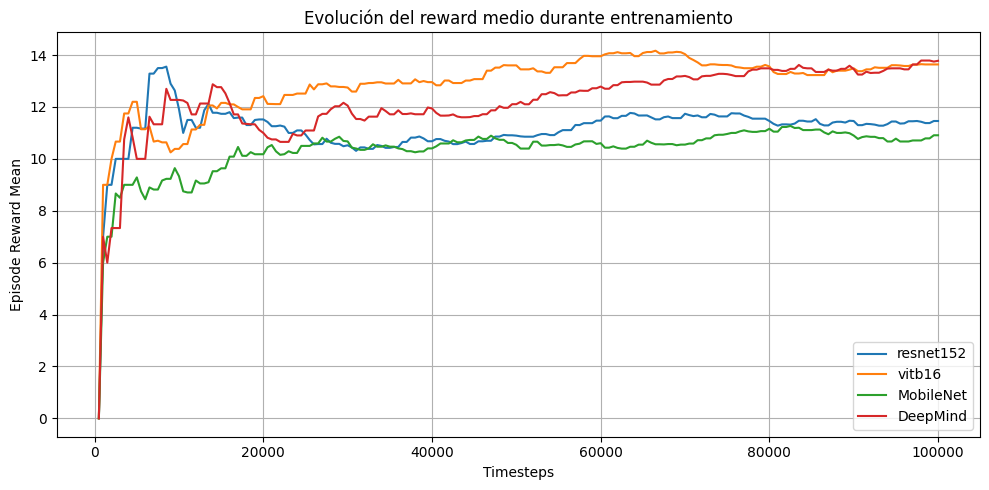

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(resnet_run["step"], resnet_run["episode_reward_mean"], label="resnet152")
plt.plot(vitb16_run["step"], vitb16_run["episode_reward_mean"], label="vitb16")
plt.plot(mobilenet_run["step"], mobilenet_run["episode_reward_mean"], label="MobileNet")
plt.plot(deepmind_run["step"], deepmind_run["episode_reward_mean"], label="DeepMind")

plt.xlabel("Timesteps")
plt.ylabel("Episode Reward Mean")
plt.title("Evolución del reward medio durante entrenamiento")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Aparentemente el mejor rendimiento en corto tiempo lo obtiene vit16b, seguido por Deepmind que lo supero en sus etapas finales. Sin embargo, se debe calcular el tiempo de entrenamiento para determinar cuál es el más eficiente.

In [46]:
# los timesteps dividido por el tiempo total de entrenamiento en segundos
resnet_time = 1e5 / (get_duration(resnet_run_id) / 1e3)
vitb16_time = 1e5 / (get_duration(vitb16_run_id) / 1e3)
mobilenet_time = 1e5 / (get_duration(mobilenet_run_id) / 1e3)
deepmind_time = 1e5 / (get_duration(deepmind_run_id) / 1e3)

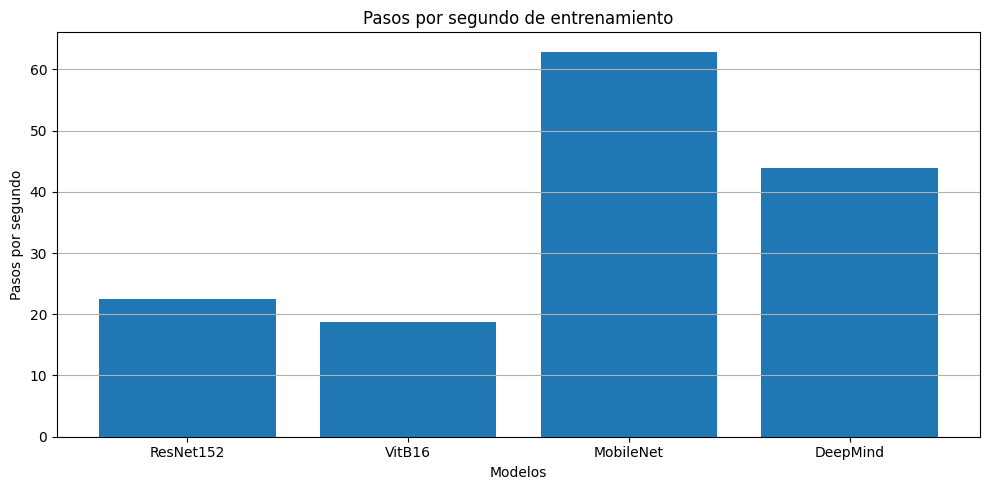

In [182]:
plt.figure(figsize=(10, 5))
plt.bar(["ResNet152", "VitB16", "MobileNet", "DeepMind"], [resnet_time, vitb16_time, mobilenet_time, deepmind_time])
plt.xlabel("Modelos")
plt.ylabel("Pasos por segundo")
plt.title("Pasos por segundo de entrenamiento")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

De esta manera eligiendo por velocidad de entrenamiento a deepmind en comparación de vitb16, ya que este pese a tener buena recompensa, sus tiempos de entrenamiento serán muy altos.

Cabe aclarar que como se menciona anteriormente todas estas pruebas se realizan sin establecer el rango de píxeles de 0 a 1, ya que en esos casos no se logra entrenar el modelo. Aunque se realizaron varias pruebas con diferentes hiperparametros con este procesamiento como se puede apreciar a continuación.

## 4.2 Pruebas con datos normalizados

In [108]:
failed_run = {
    "custom_DeepMind_v2_4_RMS_pen":"4d07242cd3c74cd0afa66e5a661dc034",
    "custom_DeepMind_v3_4":"adba373efc2c4adf9d6a74b759bf205e",
    "custom_DeepMind_v3_4_2":"6c61b265380040718c3851c8e4126d8b",
    "custom_DeepMind_v3_4_3":"adba373efc2c4adf9d6a74b759bf205e",
}

In [109]:
failed_runs = {name : get_metric_history(run_id, "episode_reward_mean") for name, run_id in failed_run.items()}

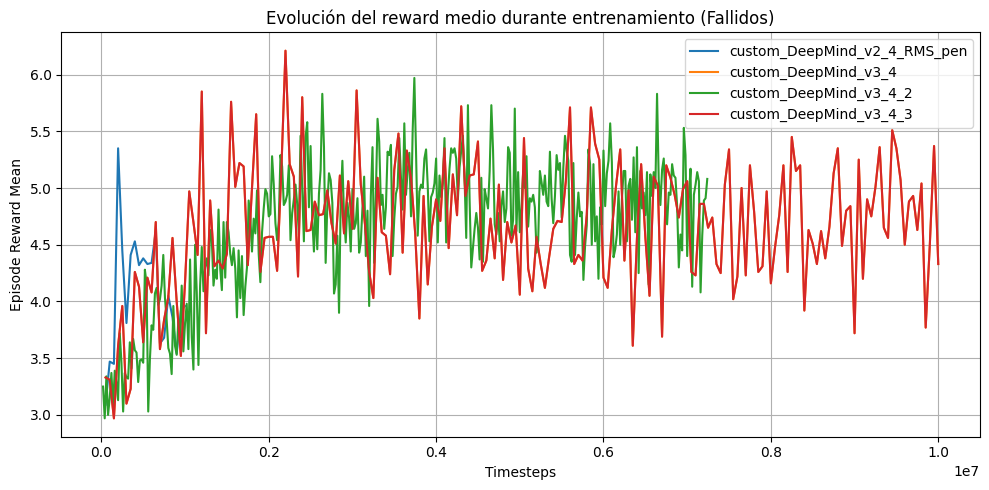

In [110]:
plt.figure(figsize=(10, 5))
for name, run in failed_runs.items():
    plt.plot(run["step"], run["episode_reward_mean"], label=name)
plt.xlabel("Timesteps")
plt.ylabel("Episode Reward Mean")
plt.title("Evolución del reward medio durante entrenamiento (Fallidos)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [111]:
def get_hiperparameters(run_id):
    run = client.get_run(run_id)
    params = run.data.params
    return {k: v for k, v in params.items()}

In [112]:
hiper_params = {name: get_hiperparameters(run_id) for name, run_id in failed_run.items()}

for name, params in hiper_params.items():
    print(f"{name}:")
    for key, value in params.items():
        print(f"  {key}: {value}")
    print()

custom_DeepMind_v2_4_RMS_pen:
  frame_skip: 4
  learning_rate: 0.00025
  gamma: 0.99
  exploration_fraction: 0.1
  exp_name: custom_DeepMind_v2_4_RMS_pen
  total_timesteps: 1000000
  buffer_size: 1000000
  optimizer_class: RMSprop
  exploration_initial_eps: 1.0
  n_stack: 4
  env_name: SpaceInvadersNoFrameskip-v4
  file_name: models/custom_DeepMind_v3_4_RMS_pen.zip
  target_update_interval: 1000
  learning_starts: 10000
  batch_size: 32
  penalized_repeat: 0.25
  num_episodes: 100
  exploration_final_eps: 0.01

custom_DeepMind_v3_4:
  frame_skip: 4
  learning_rate: 0.00025
  gamma: 0.99
  exploration_fraction: 0.1
  exp_name: custom_DeepMind_v3_4
  total_timesteps: 10000000
  buffer_size: 1000000
  optimizer_class: RMSprop
  exploration_initial_eps: 1.0
  n_stack: 4
  env_name: SpaceInvadersNoFrameskip-v4
  file_name: models/custom_DeepMind_v3_4.zip
  target_update_interval: 10000
  learning_starts: 50000
  batch_size: 32
  penalized_repeat: 0.25
  num_episodes: 100
  exploration_final

De los cuales las acciones de cada modelo se pueden observar a continuación:

In [113]:
actions = [f"action_{i}_percentage" for i in range(6)]
def get_actions(run_id):
    actions_list = [get_metric_history(run_id, action) for action in actions]
    return actions_list


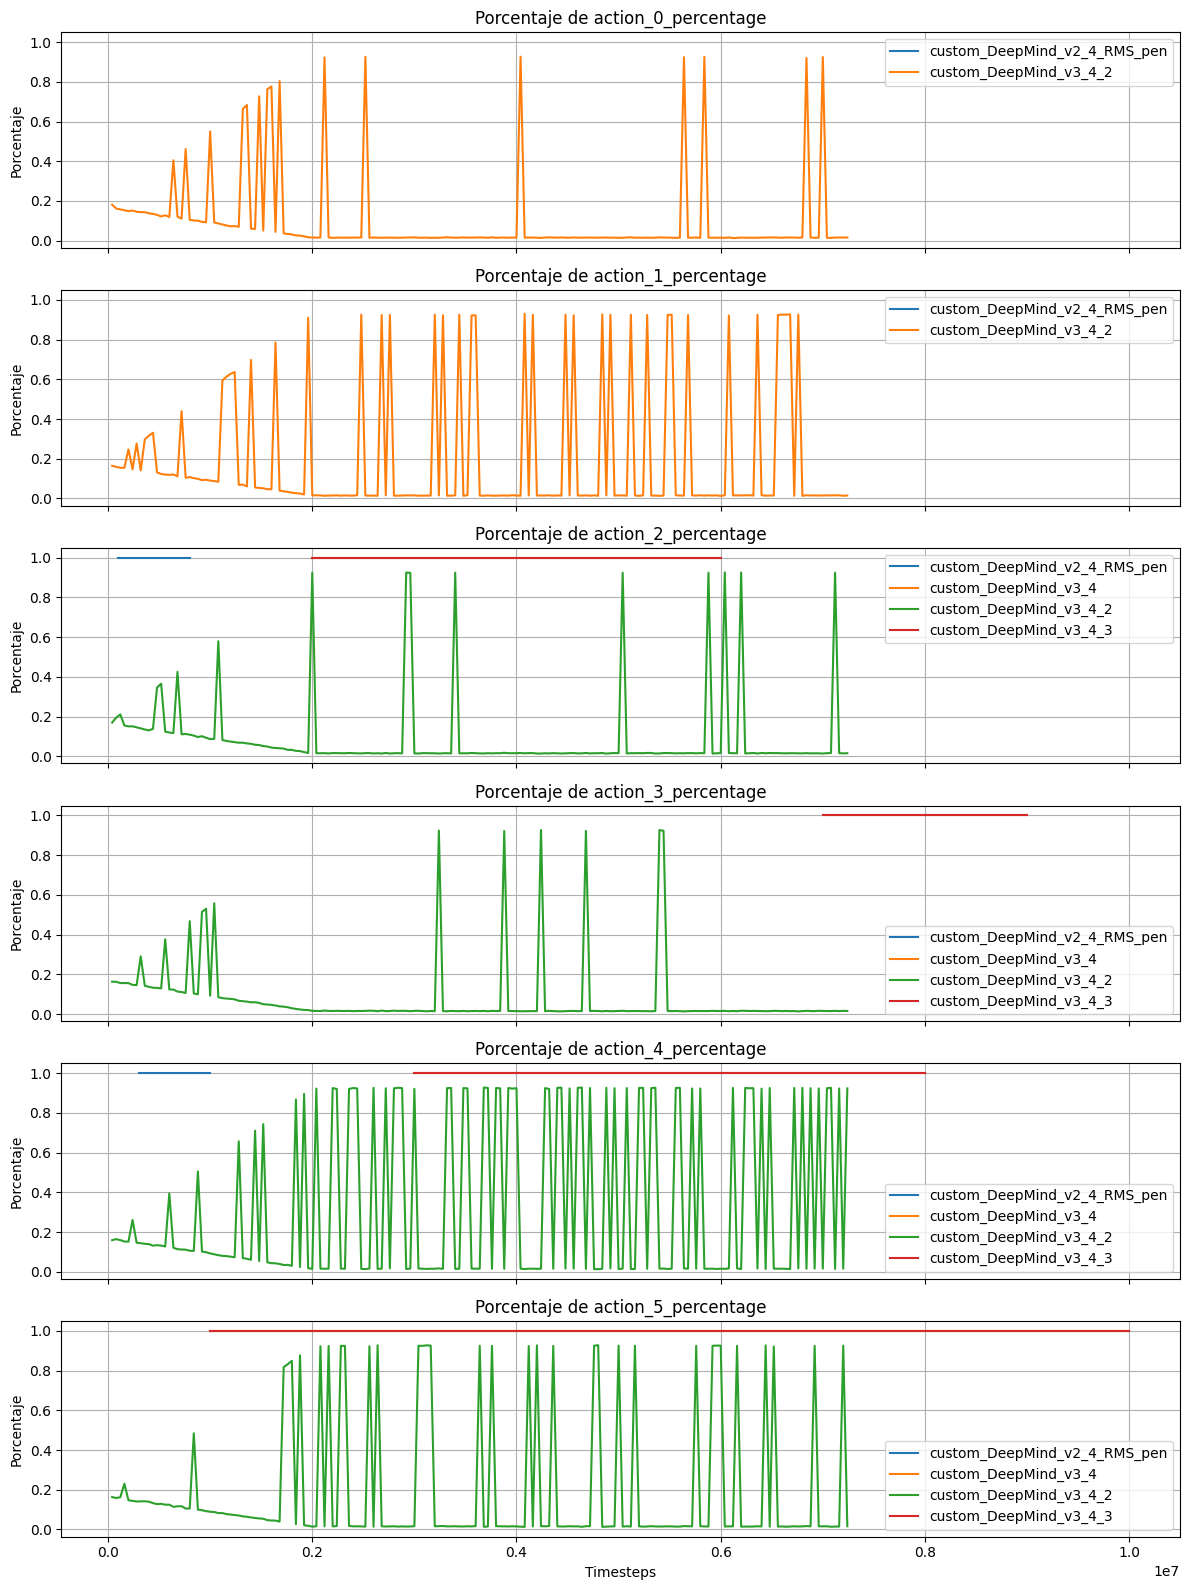

In [114]:
actions_runs = {name: get_actions(run_id) for name, run_id in failed_run.items()}

actions_data = actions_runs["custom_DeepMind_v2_4_RMS_pen"]

model_names = list(actions_runs.keys())
num_actions = len(actions)
fig, axes = plt.subplots(num_actions, 1, figsize=(12, 16), sharex=True)
for i, ax in enumerate(axes):
    for model_name in model_names:
        action_df = actions_runs[model_name][i]
        if action_df.empty:
            continue
        ax.plot(action_df["step"], action_df[actions[i]], label=model_name)
    ax.set_title(f"Porcentaje de {actions[i]}")
    ax.set_ylabel("Porcentaje")
    ax.legend()
    ax.grid()
axes[-1].set_xlabel("Timesteps")
plt.tight_layout()
plt.show()


Así observando el mismo patron independiente de las variaciones de hiperparametros o penalizaciones de repetición el modelo no logra aprender cuando los valores de los píxeles se encuentran entre 0 y 1, así que en las pruebas consiguientes se usan sus valores de 0 a 255.

## 4.3 Elección de hiperparámetros

De esta forma, se eligen los hiperparametros basandonos en modelos preentrenados de Deepmind (Mnih et al., 2015) y de los encontrados en la colección de stable baselines 3 (sb3 (Stable-Baselines3), 2022).




In [104]:
# Función para concatenar métricas de varias runs secuenciales
def concatenar_runs(run_ids, metric_names):
    dfs = []
    step_offset = 0

    for run_id in run_ids:
        df_parts = []
        for metric in metric_names:
            df_metric = get_metric_history(run_id, metric)
            df_metric.set_index("step", inplace=True)
            df_parts.append(df_metric)

        df = pd.concat(df_parts, axis=1).reset_index()

        # Ajustar los steps para que continúen secuencialmente
        df["step"] = df["step"] + step_offset
        step_offset = df["step"].iloc[-1] + 1

        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

Así con una aproximación inicial de 10 M de timesteps, se entrenan modelos de DQN, QRDQN, A2C y PPO con los siguientes hiperparámetros:

In [194]:
dqn_run_id = "0955c0e073e54ca58b126c8d209dd4b9"
df_dqn_concat = concatenar_runs([dqn_run_id], ["episode_reward_mean", "episode_reward_std", "test_reward", "test_reward_std"])
hiper_params = get_hiperparameters(dqn_run_id)

print("Hiperparámetros del modelo DQN:")
for key, value in hiper_params.items():
    print(f"{key}: {value}")

Hiperparámetros del modelo DQN:
frame_skip: 4
learning_rate: 0.0001
gamma: 0.99
exploration_fraction: 0.1
exp_name: custom_DeepMind_v4_4
env_var: 1
total_timesteps: 10000000
buffer_size: 1000000
optimizer_class: Adam
exploration_initial_eps: 1.0
n_stack: 4
env_name: SpaceInvadersNoFrameskip-v4
file_name: models/custom_DeepMind_v4_4.zip
target_update_interval: 10000
learning_starts: 100000
batch_size: 32
penalized_repeat: 0.25
num_episodes: 100
exploration_final_eps: 0.01


Cabe resaltar que en el caso de modelos como DQN, se usa un porcentaje de exploración del 10 % de los timesteps con un decremento lineal desde 1.0 hasta 0.01, esto con la intención de que al inicio el modelo explore el entorno y luego explote y refine las mejores acciones o tácticas aprendidas.

Y en el caso de DQN a diferencia del artículo principal (Mnih et al., 2015) se usa Adam en vez de RMSprop, ya que se encuentra que da más estabilidad al entrenamiento.

In [190]:
# --- QRDQN (una única run) ---
qrdqn_run_id = "78cd4d25f19e4ed996d0d864f1969eb4"
df_qrdqn_concat = concatenar_runs([qrdqn_run_id], ["episode_reward_mean", "episode_reward_std", "test_reward", "test_reward_std"])
hiper_params = get_hiperparameters(qrdqn_run_id)

print("Hiperparámetros del modelo QRDQN:")
for key, value in hiper_params.items():
    print(f"{key}: {value}")

Hiperparámetros del modelo QRDQN:
frame_skip: 4
exploration_fraction: 0.025
exp_name: custom_DeepMind_v3_4_qrdqn
env_var: 1
total_timesteps: 10000000
optimizer_class: RMSprop
exploration_initial_eps: 1.0
n_stack: 4
env_name: SpaceInvadersNoFrameskip-v4
file_name: models/custom_DeepMind_v3_4_qrdqn.zip
target_update_interval: 10000
learning_starts: 50000
batch_size: 32
penalized_repeat: 0.25
num_episodes: 100
exploration_final_eps: 0.1


En este caso la fracción de entrenamiento es menor que el DQN, ya que al usar QRDQN se busca una mayor estabilidad de entrenamiento y una mejor convergencia, porque se usa una aproximación de la distribución de las recompensas en vez de un valor único como en DQN. Esto permite al modelo aprender de manera más robusta y evitar problemas de sobreajuste a acciones específicas (Dabney et al., 2017).

In [191]:
# --- Concatenar PPO (de 0 a 29.7M timesteps) ---
ppo_run_ids = [
    "d5750967396d4e5b97e4ef2e72979f21",  # 0 a 10M
    "95c2decd982545278b2929f016ad6d44",  # 10M a 17.5M
    "fcb164f883fe4ab2ad719a0fe176d493"   # 17.5M a 29.7M
]

df_ppo_concat = concatenar_runs(ppo_run_ids, ["episode_reward_mean", "episode_reward_std", "test_reward", "test_reward_std"])

hiper_params = get_hiperparameters(ppo_run_ids[0])
print("Hiperparámetros del modelo PPO:")
for key, value in hiper_params.items():
    print(f"{key}: {value}")


Hiperparámetros del modelo PPO:
clip_range: <function get_linear_fn.<locals>.func at 0x7f484d82e5c0>
frame_skip: 4
learning_rate: <function get_linear_fn.<locals>.func at 0x7f484d82e520>
exp_name: deepmind_zoo_imp_ppo
env_var: 8
ent_coef: 0.01
total_timesteps: 10000000
vf_coef: 0.5
n_steps: 128
n_stack: 4
n_epochs: 4
env_name: SpaceInvadersNoFrameskip-v4
file_name: models/deepmind_zoo_imp_ppo.zip
batch_size: 256
num_episodes: 100


En los caos de los algoritmos on-policy como A2C y PPO se aprovecha la paralelización de los entornos lo que le da mayor velocidad de convergencia comparada con los off-policy. En el caso de PPO se adiciona el cliping con una función lineal decreciente de 0.1 a 0.01, esto para evitar que el modelo se desestabilice al actualizar las políticas y así mejorar la estabilidad del entrenamiento, facilitando la exploración y la explotación de acciones (Schulman et al., 2017).

De manera similar para la elección del coeficiente de entropía, se usa un valor de 0.01, lo que permite al modelo explorar más acciones y evitar caer en políticas subóptimas, ya que fomenta la exploración de acciones menos probables (Schulman et al., 2017). Y para el caso del coeficiente de valor se usa un valor de 0.5, lo que permite al modelo no desviarse de la política actual lo que ayuda a la estabilidad de entrenamiento (Schulman et al., 2017).

Además de en este caso usar como optimizador RMSprop en vez de adam con una caida lineal de 2.5e-4 a 1e-5 con el fin de que al final del entrenamiento el modelo solo se concentre en explotar las mejores acciones aprendidas.

In [192]:
# --- Concatenar A2C (de 0 a 36.6M timesteps) ---
a2c_run_ids = [
    "196919f796824d74aefce46a20d0c44f",  # 0 a 10M
    "d29144d2e70447c5887a0bcd125c2b1a",  # 10M a 16.6M
    "f445012c13154edcbadfe3ed0f7187ef"   # 16.6M a 36.6M
]

df_a2c_concat = concatenar_runs(a2c_run_ids, ["episode_reward_mean", "episode_reward_std", "test_reward", "test_reward_std"])
hiper_params = get_hiperparameters(a2c_run_ids[0])

print("Hiperparámetros del modelo A2C:")
for key, value in hiper_params.items():
    print(f"{key}: {value}")

Hiperparámetros del modelo A2C:
normalize: False
frame_skip: 4
learning_rate: 0.001
exp_name: deepmind_zoo_imp_a2c
env_var: 16
ent_coef: 0.01
total_timesteps: 10000000
vf_coef: 0.25
n_stack: 1
env_name: SpaceInvadersNoFrameskip-v4
file_name: models/deepmind_zoo_imp_a2c.zip
num_episodes: 100


En el caso de A2C, se usa solo una imagen en vez de un set de imágenes ya que se encuentra que da mejores resultados que con un stack de estas. Con la unica modificación de hiperparametros es el coeficiente de valor que igual que PPO se usa para controlar la política y el valor mejorando la estabilidad al ser políticas paralelizables.

In [137]:
stack_4_a2c_run = "9b35fcfdbb69459a8bd4ec429b0ec3cb"
data = get_metric_history(stack_4_a2c_run, "episode_reward_mean")
print(client.get_run(stack_4_a2c_run).info.run_name)
print("máximo valor obtenido con 4 stacks en ppo", max(data.episode_reward_mean), "con un total de episodios de", max(data.step))

A2C_Run_deepmind_zoo_imp_a2c
máximo valor obtenido con 4 stacks en ppo 4.22 con un total de episodios de 3200000


Gracias a su capacidad de paralelización, A2C y PPO se entrenan durante 36.6 M y 29.7 M de timesteps respectivamente, lo que permite una convergencia más rápida y eficiente en comparación con DQN y QRDQN, que requieren más tiempo para alcanzar un rendimiento óptimo debido a su naturaleza off-policy.

## 4.4 Comparación de modelos

Evolución del reward medio durante el entrenamiento

Se muestra la evolución del `episode_reward_mean` por timesteps para cada algoritmo. Esta gráfica permite observar el ritmo y la capacidad de aprendizaje a lo largo del entrenamiento.


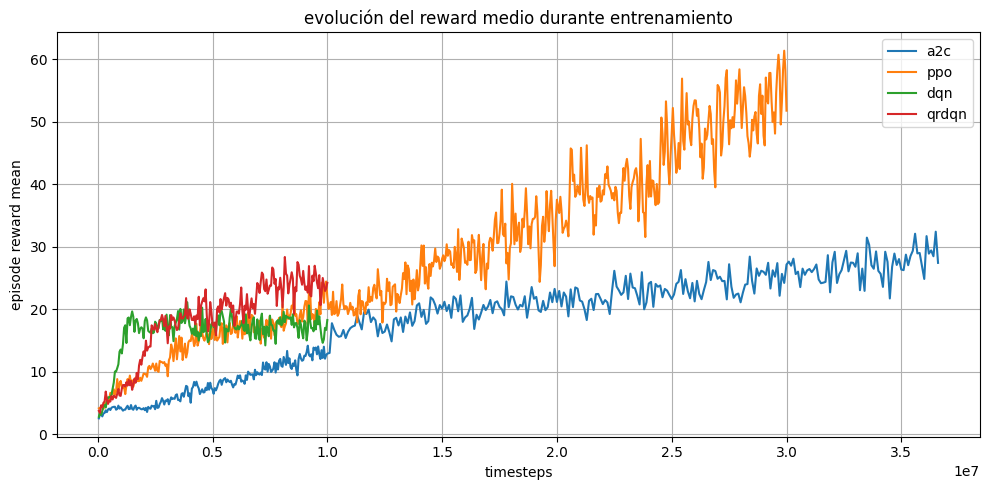

In [195]:
plt.figure(figsize=(10, 5))
plt.plot(df_a2c_concat["step"], df_a2c_concat["episode_reward_mean"], label="a2c")
plt.plot(df_ppo_concat["step"], df_ppo_concat["episode_reward_mean"], label="ppo")
plt.plot(df_dqn_concat["step"], df_dqn_concat["episode_reward_mean"], label="dqn")
plt.plot(df_qrdqn_concat["step"], df_qrdqn_concat["episode_reward_mean"], label="qrdqn")

plt.xlabel("timesteps")
plt.ylabel("episode reward mean")
plt.title("evolución del reward medio durante entrenamiento")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### Evolución del test reward promedio en el entrenamiento

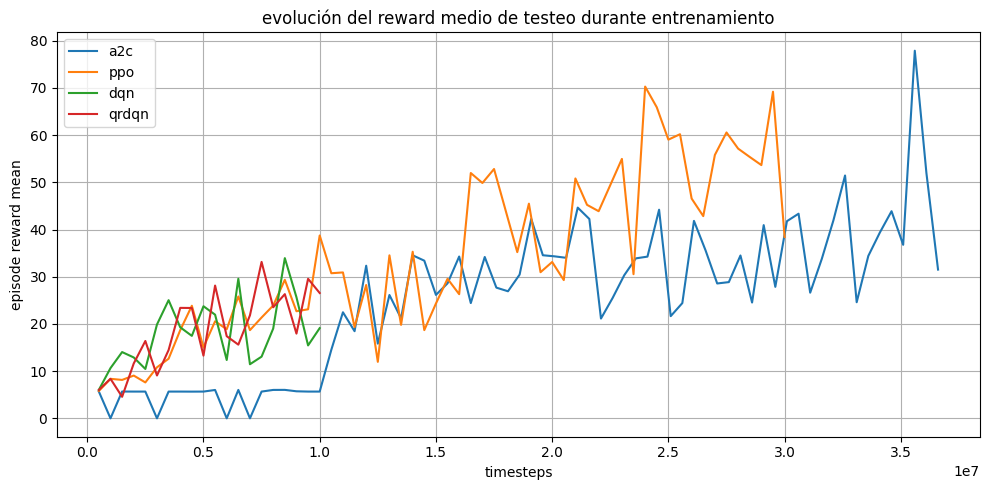

In [196]:
plt.figure(figsize=(10, 5))
plt.plot(df_a2c_concat[df_a2c_concat["test_reward"].notna()]["step"], df_a2c_concat[df_a2c_concat["test_reward"].notna()]["test_reward"], label="a2c")
plt.plot(df_ppo_concat[df_ppo_concat["test_reward"].notna()]["step"], df_ppo_concat[df_ppo_concat["test_reward"].notna()]["test_reward"], label="ppo")
plt.plot(df_dqn_concat[df_dqn_concat["test_reward"].notna()]["step"], df_dqn_concat[df_dqn_concat["test_reward"].notna()]["test_reward"], label="dqn")
plt.plot(df_qrdqn_concat[df_qrdqn_concat["test_reward"].notna()]["step"], df_qrdqn_concat[df_qrdqn_concat["test_reward"].notna()]["test_reward"], label="qrdqn")


plt.xlabel("timesteps")
plt.ylabel("episode reward mean")
plt.title("evolución del reward medio de testeo durante entrenamiento")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### Estabilidad del entrenamiento (episode_reward_std)

Se compara la desviación estándar del reward por episodio para cada algoritmo. Esto permite evaluar la **consistencia** del aprendizaje, donde un `std` más bajo indica comportamiento más estable.


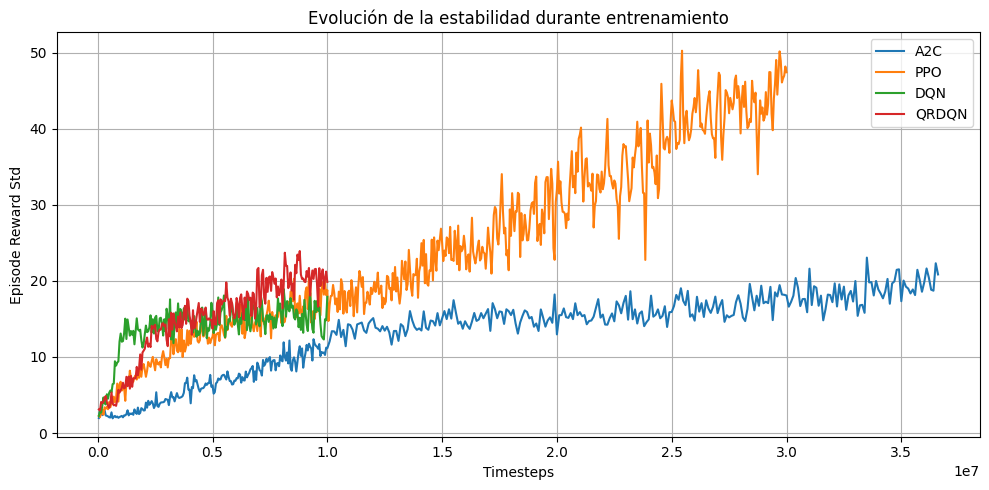

In [197]:
plt.figure(figsize=(10, 5))
plt.plot(df_a2c_concat["step"], df_a2c_concat["episode_reward_std"], label="A2C")
plt.plot(df_ppo_concat["step"], df_ppo_concat["episode_reward_std"], label="PPO")
plt.plot(df_dqn_concat["step"], df_dqn_concat["episode_reward_std"], label="DQN")
plt.plot(df_qrdqn_concat["step"], df_qrdqn_concat["episode_reward_std"], label="QRDQN")

plt.xlabel("Timesteps")
plt.ylabel("Episode Reward Std")
plt.title("Evolución de la estabilidad durante entrenamiento")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### Estabilidad del test reward (test_reward_std)

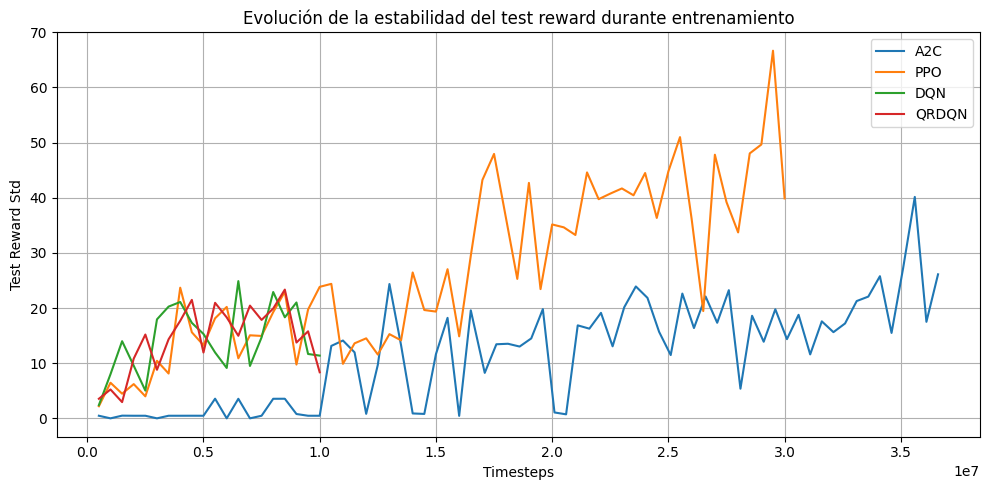

In [198]:
plt.figure(figsize=(10, 5))
plt.plot(df_a2c_concat[df_a2c_concat["test_reward_std"].notna()]["step"], df_a2c_concat[df_a2c_concat["test_reward_std"].notna()]["test_reward_std"], label="A2C")
plt.plot(df_ppo_concat[df_ppo_concat["test_reward_std"].notna()]["step"], df_ppo_concat[df_ppo_concat["test_reward_std"].notna()]["test_reward_std"], label="PPO")
plt.plot(df_dqn_concat[df_dqn_concat["test_reward_std"].notna()]["step"], df_dqn_concat[df_dqn_concat["test_reward_std"].notna()]["test_reward_std"], label="DQN")
plt.plot(df_qrdqn_concat[df_qrdqn_concat["test_reward_std"].notna()]["step"], df_qrdqn_concat[df_qrdqn_concat["test_reward_std"].notna()]["test_reward_std"], label="QRDQN")

plt.xlabel("Timesteps")
plt.ylabel("Test Reward Std")
plt.title("Evolución de la estabilidad del test reward durante entrenamiento")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Comparación entre rendimiento en entrenamiento y test

Aquí se evalúa si el comportamiento observado durante el entrenamiento (`episode_reward_mean`) se mantiene en evaluación (`test_reward`).


In [199]:
# Diccionario con los run_id finales de cada algoritmo
runs_finales = {
    "A2C": df_a2c_concat[["episode_reward_mean", "test_reward"]],
    "PPO": df_ppo_concat[["episode_reward_mean", "test_reward"]],
    "DQN": df_dqn_concat[["episode_reward_mean", "test_reward"]],
    "QRDQN": df_qrdqn_concat[["episode_reward_mean", "test_reward"]],
}
datos = []

for nombre, run_id in runs_finales.items():
    # Obtener historia de métricas

    train_values = run_id["episode_reward_mean"]
    test_values = run_id["test_reward"]

    max_train = train_values.max()
    max_test = test_values.max()
    diff = max_train - max_test
    datos.append({
        "Algoritmo": nombre,
        "Max Train Reward": round(max_train, 2),
        "Max Test Reward": round(max_test, 2),
        "Diferencia (Max Train - Max Test)": round(diff, 2)
    })

# Mostrar tabla
df_comparacion = pd.DataFrame(datos)
df_comparacion.sort_values("Algoritmo", inplace=True)
df_comparacion.reset_index(drop=True, inplace=True)
df_comparacion



,Algoritmo,Max Train Reward,Max Test Reward,Diferencia (Max Train - Max Test)
0,A2C,32.41,77.88,-45.47
1,DQN,21.12,33.94,-12.82
2,PPO,61.36,70.28,-8.92
3,QRDQN,28.36,33.14,-4.78


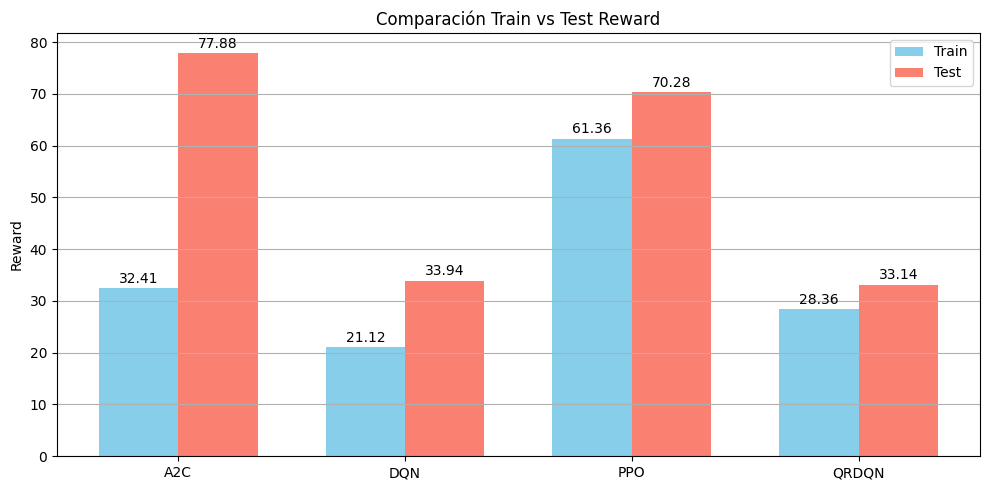

In [200]:
# Crear la gráfica
algoritmos = df_comparacion["Algoritmo"]
train = df_comparacion["Max Train Reward"]
test = df_comparacion["Max Test Reward"]
diff = df_comparacion["Diferencia (Max Train - Max Test)"]

x = np.arange(len(algoritmos))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, train, width, label="Train", color="skyblue")
plt.bar(x + width/2, test, width, label="Test", color="salmon")

for i in range(len(x)):
    plt.text(x[i] - width/2, train[i] + 1, f"{train[i]}", ha='center')
    plt.text(x[i] + width/2, test[i] + 1, f"{test[i]}", ha='center')

plt.xticks(x, algoritmos)
plt.ylabel("Reward")
plt.title("Comparación Train vs Test Reward")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Comparación de episodios por segundo

In [203]:
ppo_time = int(client.get_run(ppo_run_ids[-1]).data.params["total_timesteps"]) / (get_duration(ppo_run_ids[-1]) / 1e3)
a2c_time = int(client.get_run(a2c_run_ids[-1]).data.params["total_timesteps"]) / (get_duration(a2c_run_ids[-1]) / 1e3)
dqn_time = int(client.get_run(dqn_run_id).data.params["total_timesteps"]) / (get_duration(dqn_run_id) / 1e3)
qrdqn_time = int(client.get_run(qrdqn_run_id).data.params["total_timesteps"]) / (get_duration(qrdqn_run_id) / 1e3)

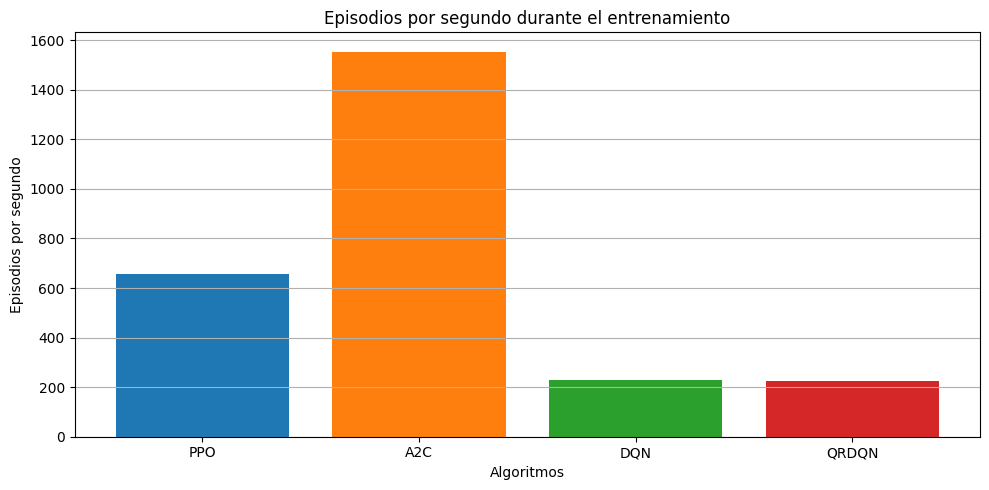

In [204]:
plt.figure(figsize=(10, 5))
plt.bar(["PPO", "A2C", "DQN", "QRDQN"], [ppo_time, a2c_time, dqn_time, qrdqn_time], color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])
plt.xlabel("Algoritmos")
plt.ylabel("Episodios por segundo")
plt.title("Episodios por segundo durante el entrenamiento")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## 4.5 Comparación de videos

Los videos se encuentran disponibles en:

- [A2C](https://youtu.be/q_kESOWg7TQ)
- [PPO](https://youtu.be/Y_bcT4CqhOM)
- [DQN](https://youtu.be/KHJot35lHX4)
- [QRDQN](https://youtu.be/xYjKdsSRJWo)

Donde se puede observar que pese a que A2C presenta mejores metricas en la parte de test, sufre de un sobreajuste con el entorno, al acostumbrarse a la "vida episodica" y al no tener información espacial como sus otras contrapartes, así que cuando está en un entorno real con 3 vidas le cuesta más adaptarse y jugar.
Por otra parte, PPO logra un mejor rendimiento llegando a "ganar" varias veces y obteniendo puntuaciones más altas que DQN y QRDQN.

Adicionalmente, se evaluó, la capacidad de paralelización de QRDQN y DQN, aunque en ambos casos no se lograba una mejora significativa, esto principalmente debido a los cambios de política drasticos y su falta de control frente a esto.

In [161]:
failed_paralelization = {
    "Run_custom_DeepMind_v3_4_qrdqn":"fd952e661fd34080b943e4555a32fe98",
    "custom_DeepMind_v3_4_dqn":"e68170d3002f41529497b13366d51e06",
}


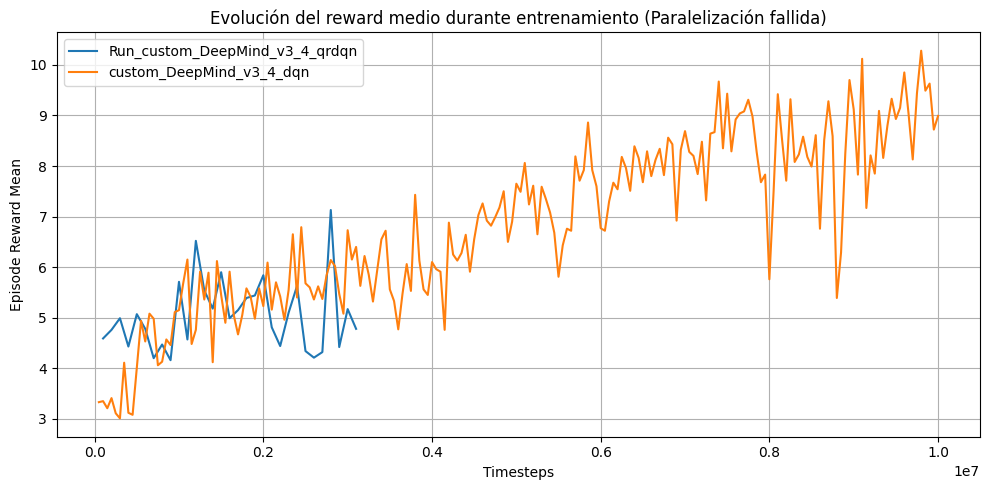

In [163]:
failed_paralelization_runs = {name: get_metric_history(run_id, "episode_reward_mean") for name, run_id in failed_paralelization.items()}


plt.figure(figsize=(10, 5))
for name, run in failed_paralelization_runs.items():
    plt.plot(run["step"], run["episode_reward_mean"], label=name)
plt.xlabel("Timesteps")
plt.ylabel("Episode Reward Mean")
plt.title("Evolución del reward medio durante entrenamiento (Paralelización fallida)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## 4.6 Optimización de hiperparámetros

En este caso al a2c y ppo ser paralelizables, se realiza una optimización de hiperparámetros con Optuna, usando solo a2c para encontrar el hiperparámetro más sensible y así para estudios futuros poder enfatizar en este y mejorar el rendimiento del modelo.

El estudio se realizó con la siguiente configuración en 20 iteraciones, cada 10 M de episodios cada uno:

| Hiperparámetro  | Tipo          | Rango          |
| --------------- | ------------- | -------------- |
| `ent_coef`      | `float (log)` | `[0.001, 0.1]` |
| `vf_coef`       | `float (log)` | `[0.01, 0.5]`  |
| `learning_rate` | `float (log)` | `[1e-4, 1e-3]` |
| `eps`           | `float (log)` | `[1e-6, 1e-4]` |


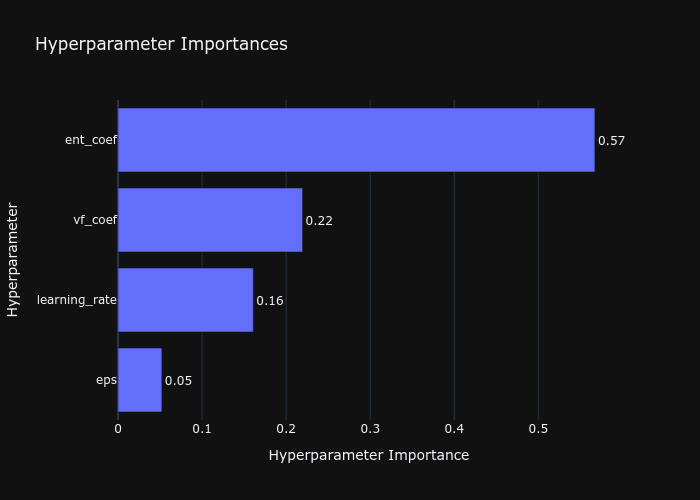

In [6]:
study = optuna.load_study(
    study_name="a2c_optimization", storage="sqlite:///optuna_storage/a2c_spaceinvaders.db")
fig = plot_param_importances(study)
fig.show("png")

Donde podemos observar que el hiperparámetro más sensible es ent_coef con un valor de 0.52, lo cual indica que la entropía es un factor fundamental en el rendimiento del modelo A2C en este entorno, lo cual se sugiere tener más en cuenta para futuros estudios y optimizaciones.

## 5. Conclusiones

### 5.1 Elección de la arquitectura visual

Durante las primeras etapas del proyecto se evaluaron diferentes arquitecturas de redes convolucionales como extractores de características visuales para el entorno. Las opciones consideradas incluyeron modelos modernos y complejos como ResNet152, MobileNet y ViT-B16, así como la arquitectura clásica DeepMindCNN, propuesta en el trabajo original de DQN (Mnih et al., 2015).

La arquitectura DeepMindCNN, basada en la red propuesta en el trabajo original de DQN por Mnih et al. (2015), ofreció ventajas clave para este proyecto:

Eficiencia computacional: Su diseño es inherentemente ligero. Incluye tres capas convolucionales y una capa oculta densa. Esta configuración se ajusta perfectamente a entornos de baja resolución como Atari, para los cuales fue específicamente concebida.

Compatibilidad con el entorno: Fue diseñada para operar con imágenes en escala de grises preprocesadas y apiladas, una representación que se utiliza en entornos como Space Invaders.

Estabilidad del aprendizaje: Si bien la estabilidad no depende únicamente de la arquitectura, la DeepMindCNN, al integrarse con técnicas algorítmicas como el "experience replay" y las redes objetivo en DQN, o los métodos asíncronos en A2C, demostró curvas de aprendizaje estables y reproducibles. Los autores de DQN no reportaron problemas de divergencia.

Comparabilidad entre algoritmos: La estandarización de esta arquitectura en distintos algoritmos de aprendizaje por refuerzo, como DQN, A2C, PPO y QR-DQN, garantiza que las diferencias de rendimiento observadas provienen de las características algorítmicas y no de variaciones en el preprocesamiento visual o en la extracción de características.

Por estas razones, la DeepMindCNN fue seleccionada como arquitectura estándar para todos los experimentos finales, asegurando así eficiencia, robustez y coherencia metodológica en la evaluación de los algoritmos.
### 5.2 Impacto de los hiperparámetros

La configuración de hiperparámetros empleada en este proyecto fue elaborada a partir de un conjunto de referencias consolidadas en la literatura y ajustada mediante observación empírica. Se tomaron como base los modelos originales de DeepMind para DQN (Mnih et al., 2015), las recomendaciones teóricas y prácticas propuestas por Schulman et al. (2017) en algoritmos on-policy como PPO y A2C, así como los avances en aprendizaje distribucional con QR-DQN (Dabney et al., 2017). Adicionalmente, se consultaron configuraciones y buenas prácticas recogidas en la implementación de la biblioteca Stable-Baselines3 (SB3, 2022). Estos valores fueron adaptados cuidadosamente a las características del entorno SpaceInvadersNoFrameskip-v4 y a las limitaciones computacionales de los recursos disponibles, con el objetivo de lograr un equilibrio entre rendimiento, estabilidad y eficiencia.

La selección de hiperparámetros permitió a cada algoritmo operar dentro de sus fortalezas, optimizando el uso de recursos disponibles. Las configuraciones aplicadas a PPO y A2C destacaron por su equilibrio entre velocidad de convergencia, estabilidad y rendimiento, mientras que las adaptaciones realizadas en DQN y QR-DQN buscaron maximizar la utilidad de los algoritmos off-policy dentro de un marco computacional limitado.

Además de evaluar la importancia de los hiperparámetros en a2c y denotar que el más importante es el coeficiente de entropía con un valor de 0.52, lo cual puede ayudar a trabajos futuros a optimizar este algoritmo en entornos similares.

### 5.3 Evaluación del rendimiento

PPO logra el mejor rendimiento general. A2C tiene un crecimiento más lento y controlado, reflejando un aprendizaje más estable pero menos ambicioso.

Estos resultados son coherentes con lo reportado por Schulman et al. (2017), donde comenta que PPO rinde mejor en Atari que A2C. Y con lo demostrado en (Mnih et al. 2015), donde se evidencia que A2C se caracteriza por su estabilidad durante el entrenamiento.

DQN y QRDQN parecen limitarse en capacidad de mejora, estabilizándose pronto sin llegar al rendimiento de PPO o A2C. Siendo dentro los resultados visiblemente mejor QRDQN que DQN

La superioridad de QRDQN sobre DQN está respaldada por métricas de rendimiento significativamente más altas y por una sólida base teórica y ventajas algorítmicas, como se desprende de (Dabney et al. 2017).

No se descarta que QRDQN pudiera superar a los algoritmos on-policy (como PPO o A2C) si se entrenara durante más tiempo, como así sucede y queda demostrado en el algoritmo Rainbow (que emplea QRDQN) en Hessel et al. (2017) da como resultado un rendimiento de vanguardia en el benchmark Atari 2600, tanto en términos de eficiencia como de rendimiento final.

Sin embargo, su alto consumo de memoria, debido al uso de un replay buffer distribuido (hasta 50 GB por 1 millón de timesteps), lo hace poco viable para entrenamientos prolongados dentro de las restricciones de este proyecto.

En contraste, los algoritmos on-policy como PPO y A2C no requieren almacenar experiencias pasadas, lo que reduce significativamente su uso de memoria (en torno a 5–10 GB). Además, ambos son fácilmente paralelizables, lo que permite ejecutar múltiples entornos simultáneamente y acumular más timesteps en menos tiempo real. Por ejemplo, mientras 10M timesteps con DQN o QRDQN pueden tardar hasta 10 horas, PPO y A2C pueden alcanzar ese mismo volumen en 2 horas o menos gracias a su diseño paralelo.

Por estas razones prácticas (principalmente el equilibrio entre coste computacional, tiempo de entrenamiento y estabilidad), se optó por priorizar el uso y análisis extendido de PPO y A2C.

PPO es el algoritmo más recomendable, por su alto rendimiento medio, buen uso de recursos y capacidad de generalización. A2C es una buena segunda opción sobre todo si se realiza una búsqueda de hiperparámetros que tenga un buen rendimiento con un v_stack mayor que 1. Se desaconseja el uso de DQN en este entorno sin cambios sustanciales en diseño o configuración.


## Referencias

- Dabney, W., Rowland, M., Bellemare, M. G., & Munos, R. (2017). Distributional Reinforcement Learning with Quantile Regression (No. arXiv:1710.10044). arXiv. https://doi.org/10.48550/arXiv.1710.10044
- Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., Graves, A., Riedmiller, M., Fidjeland, A. K., Ostrovski, G., Petersen, S., Beattie, C., Sadik, A., Antonoglou, I., King, H., Kumaran, D., Wierstra, D., Legg, S., & Hassabis, D. (2015). Human-level control through deep reinforcement learning. Nature, 518(7540), 529-533. https://doi.org/10.1038/nature14236
- Sb3 (Stable-Baselines3). (2022, octubre 11). https://huggingface.co/sb3/models
- Schulman, J., Wolski, F., Dhariwal, P., Radford, A., & Klimov, O. (2017). Proximal Policy Optimization Algorithms (No. arXiv:1707.06347). arXiv. https://doi.org/10.48550/arXiv.1707.06347
- Hessel, M., Modayil, J., Van Hasselt, H., Schaul, T., Ostrovski, G., Dabney, W., Horgan, D., Piot, B., Azar, M., & Silver, D. (2017). Rainbow: Combining Improvements in Deep Reinforcement Learning (No. arXiv:1710.02298). arXiv. https://doi.org/10.48550/arXiv.1710.02298